In [1]:
import tensorflow as tf
# print('import tf', tf.__version__)

import os,pickle
import time
import datetime
from imp import reload
from matplotlib import pyplot as plt
import numpy as np
from sys import stdout
from units.globals import DEBUG

print('import module')
os.system('pwd')

import GAN
from GAN.dataloader import load_pair,load_image_train,load_image_test
from GAN.prep import random_jitter
from GAN.model import Generator,Discriminator
from GAN.loss import get_gen_loss,get_disc_loss

from units.base import visualize,generate_images,show
from sklearn.model_selection import train_test_split

import module


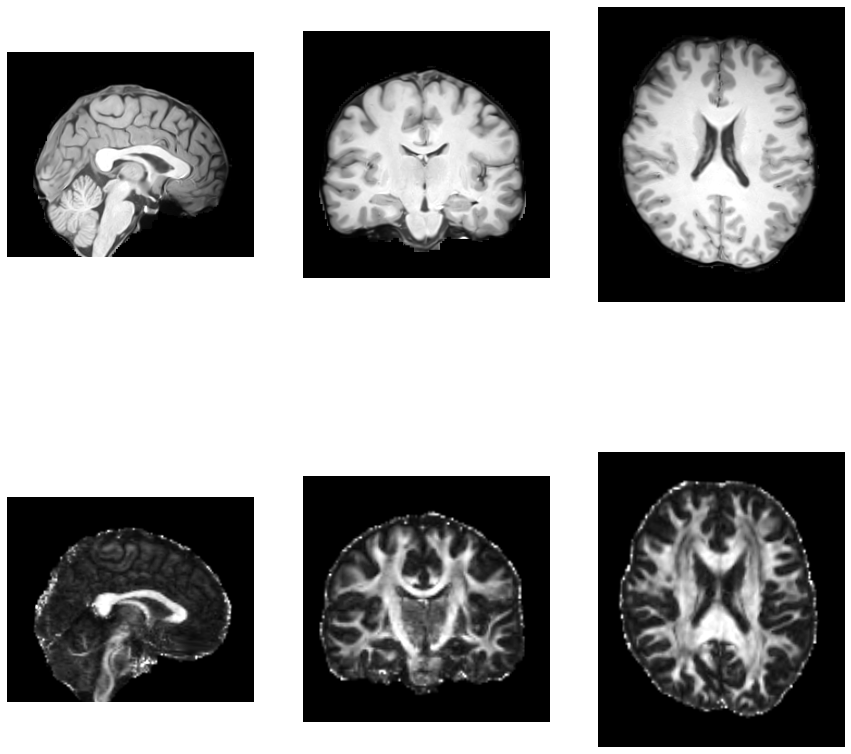

In [7]:
reload(GAN)
NEWPATH="datasets/brainmap/npdata"
data=[f"{NEWPATH}/{img}"for img in os.listdir(NEWPATH)]
demo=np.load(data[0])
t1,fa=demo[0],demo[1]
# t1[fa==0]=0
visualize([t1,fa],save_path="demo/paired.png")

100%|██████████| 400/400 [01:22<00:00,  4.84it/s]


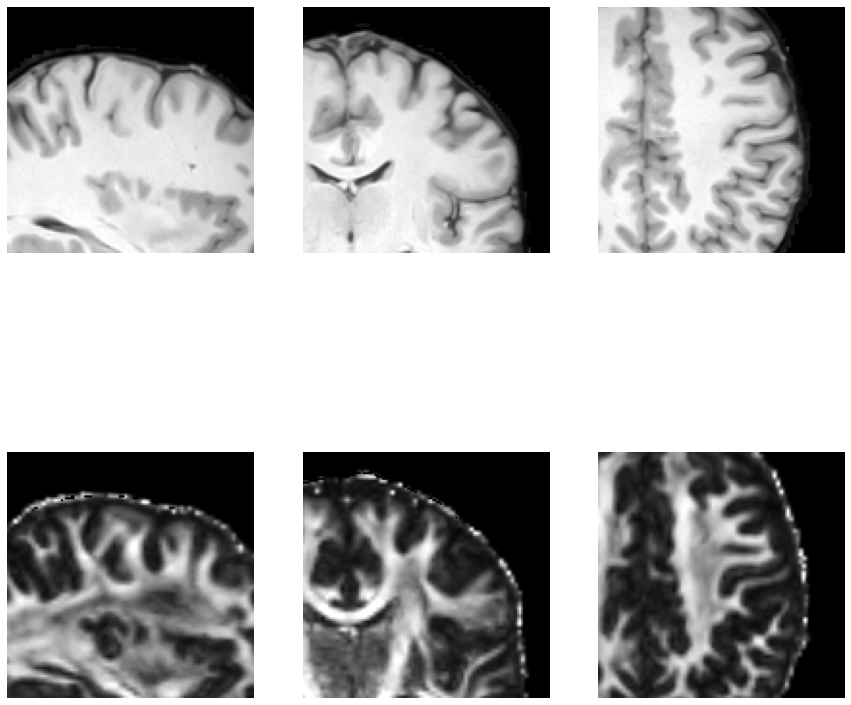

In [37]:
### visualize argument
# reload(GAN.prep)
# from GAN.prep import random_jitter
# reload(GAN.prep)
# # for i in range(1):
# st_range=np.array((227, 272, 227))-np.array((128,128,128))

# def load_demo(data):
#     st=np.random.randint(st_range)
#     ed=st+128
#     x,y=data[0][st[0]:ed[0],st[1]:ed[1],st[2]:ed[2]],data[1][st[0]:ed[0],st[1]:ed[1],st[2]:ed[2]]
#     return x,y
# t1_arg,fa_arg=load_demo([t1,fa])#Patch_extration()(t1,fa)
from tqdm import trange
# for i in trange(400):
t1_arg,fa_arg=random_jitter(demo)
# t1_arg,fa_arg=load_image_train(t1_arg,fa_arg)#,[Rotation3D(max_rate=np.pi/2)])
visualize([t1_arg,fa_arg])
np.save("demo/t1_arg",t1_arg)
np.save("demo/fa_arg",fa_arg)

In [38]:
NEWPATH="datasets/brainmap/npdata"
data=[f"{NEWPATH}/{img}"for img in os.listdir(NEWPATH)]
train_val,test=train_test_split(
    data,test_size=0.1,random_state=1919810
)
train,val=train_test_split(
    train_val,test_size=0.1,random_state=114514
)
show(f"Train len: {len(train)}")
show(f"Val len: {len(val)}")
show(f"Test len: {len(test)}")

Train len: 16
Val len: 2
Test len: 2


In [39]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 4
st_range=np.array((227, 272, 227))-np.array((128,128,128))
def load_np_data(filename,argu=False):
    if type(filename)!=str:
        filename=filename.decode()
    data=np.load(filename,mmap_mode="r")
    
    if argu:
        x,y=random_jitter(data)
    else:
        st=np.random.randint(st_range)
        ed=st+128
        x,y=data[0,st[0]:ed[0],st[1]:ed[1],st[2]:ed[2]],data[1,st[0]:ed[0],st[1]:ed[1],st[2]:ed[2]]
        mask=(x!=0)&(y!=0)
        x=x*mask;y=y*mask

    return tf.convert_to_tensor(x),tf.convert_to_tensor(y)

train_load=lambda filename:tf.numpy_function(func=load_np_data,inp=[filename,True],Tout=(tf.float32,tf.float32))
test_load=lambda filename:tf.numpy_function(func=load_np_data,inp=[filename,False],Tout=(tf.float32,tf.float32))

def get_train_ds(train):
    # train_dataset=[]
    # for t in tqdm(train):
        # train_dataset.append(load_image_train(t))
    # train_dataset=np.array(train_dataset)
    # train_dataset = list(map(load_image_train,train))
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train)
    # print(train_dataset)
    # train_dataset=load_image_train(train)
    train_dataset = train_dataset.map(map_func=train_load,num_parallel_calls=16)
    train_dataset = train_dataset.shuffle(BUFFER_SIZE,seed=114514)
    train_dataset = train_dataset.batch(BATCH_SIZE,num_parallel_calls=16)
    return train_dataset
# train_dataset=train_dataset.map(lambda x:tf.numpy_function(func=upper_case_fn,inp=[x],Tout=(tf.float64,tf.float64)))

def get_test_ds(test):
    # test_dataset=[]
    # for i in range(8):test_dataset+=[load_image_test(test_dir)for test_dir in test]
    # iplist,relist=[],[]
    # for input,real in test_dataset:
    #     iplist.append(input)
    #     relist.append(real)
    test_dataset = tf.data.Dataset.from_tensor_slices(test)
    test_dataset = test_dataset.map(map_func=test_load,num_parallel_calls=16)
    # test_dataset = test_dataset.map(lambda x:tf.numpy_function(func=load_image_test,inp=[x],Tout=(tf.float32,tf.float32)),num_parallel_calls=16,deterministic=False)
    # test_dataset = test_dataset.map(lambda x:tf.numpy_function(func=load_image_test,inp=[x],Tout=(tf.float32,tf.float32)),num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
    test_dataset = test_dataset.batch(BATCH_SIZE,num_parallel_calls=16)
    return test_dataset

train_ds,val_ds,test_ds=get_train_ds(train),get_test_ds(val),get_test_ds(test)

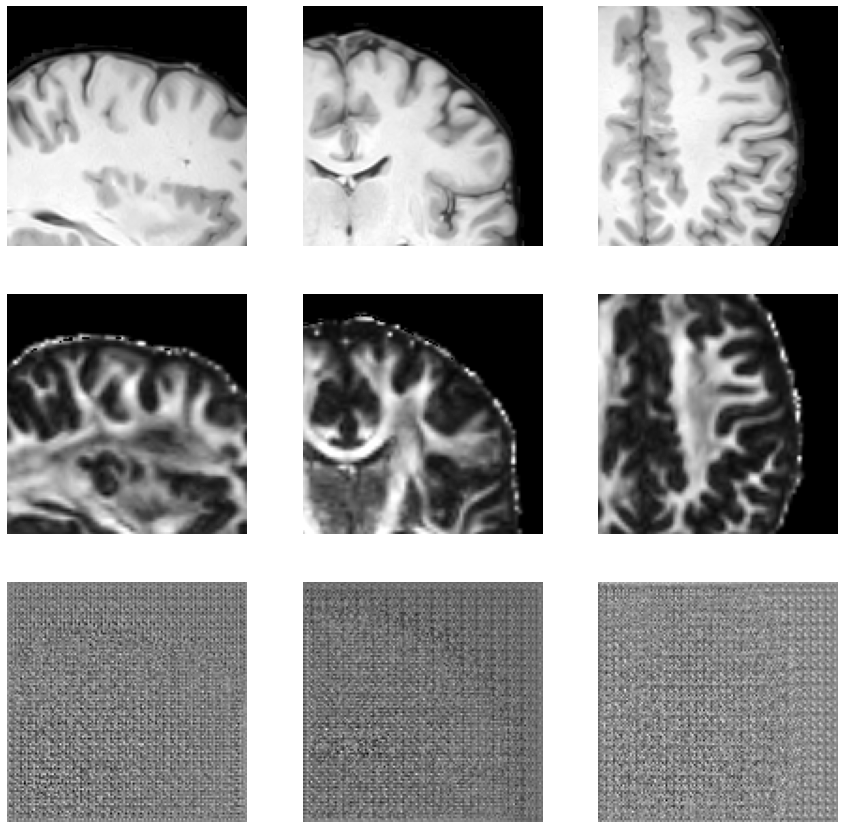

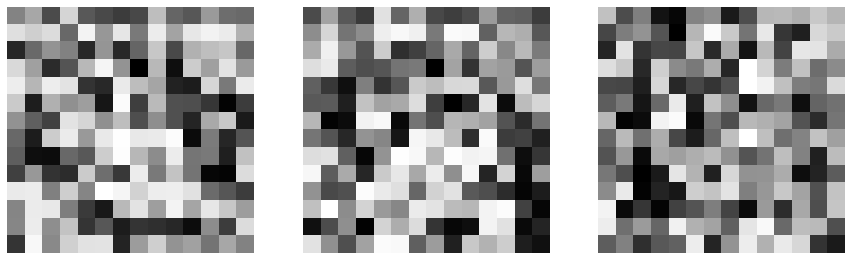

In [40]:
# del Generator
# reload(GAN)
import GAN
from GAN.model import Generator,Discriminator
tip,fip=t1_arg[tf.newaxis, ...],fa_arg[tf.newaxis, ...]
tg=Generator()
ds=Discriminator()

gen_output = tg(tip, training=False)
# print(gen_output.shape)
generate_images(tg,tip,fip)


disc_output = ds([tip,fip], training=False)
# print(gen_output.shape)
# visualize(tip[0,:,:,:])
visualize(disc_output[0,...,0])


In [41]:
gen_oper = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_oper = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

from GAN.model import Generator,Discriminator
# reload(GAN.model)
generator = Generator()
discriminator=Discriminator()
from GAN.loss import get_gen_loss,get_disc_loss
# reload(GAN.loss)
ALPHA=10
val_time=len(train_ds)//BATCH_SIZE*5
tot_step=len(train_ds)*500

In [42]:
log_dir="logs/"
this_log_dir=log_dir + "GAN_fit_L1_loss/" + f"ALPHA{ALPHA}_Step{tot_step}_" +datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(this_log_dir)
path=f"{this_log_dir}/T1_FA"
checkpoint_dir = f"{this_log_dir}/training_checkpoints"
checkpoint_prefix = checkpoint_dir+"/ckpt"
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_oper,
                                 discriminator_optimizer=disc_oper,
                                 generator=generator,
                                 discriminator=discriminator)


In [43]:
G,D=generator,discriminator
@tf.function
def train_step(img, tar, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        tar_fake = G(img, training=True)

        disc_real_output = D([img, tar], training=True)
        disc_fake_output = D([img, tar_fake], training=True)

        gen_loss, voxel_loss, gan_disc_loss = get_gen_loss(
            tar,tar_fake,disc_fake_output, ALPHA)
        disc_loss = get_disc_loss(disc_real_output, disc_fake_output)

    gen_grad = gen_tape.gradient(
        gen_loss, G.trainable_variables)
    disc_grad = disc_tape.gradient(
        disc_loss, D.trainable_variables)

    gen_oper.apply_gradients(
        zip(gen_grad, G.trainable_variables))
    disc_oper.apply_gradients(
        zip(disc_grad, D.trainable_variables))

    
    with summary_writer.as_default():
        tf.summary.scalar('gen_loss', gen_loss, step)
        tf.summary.scalar('voxel_loss', voxel_loss, step)
        tf.summary.scalar('gan_disc_loss', gan_disc_loss,step)
        tf.summary.scalar('disc_loss', disc_loss,step)
    return gen_loss, voxel_loss, gan_disc_loss, disc_loss

In [44]:
@tf.function
def test_step(img, tar):
    tar_fake = G(img, training=False)

    disc_real_output = D([img, tar], training=False)
    disc_fake_output = D([img, tar_fake], training=False)
    disc_loss = get_disc_loss(disc_real_output, disc_fake_output)

    gen_loss, voxel_loss, gan_disc_loss = get_gen_loss(tar, tar_fake, disc_fake_output, ALPHA)
        
    return gen_loss, voxel_loss, gan_disc_loss, disc_loss

In [45]:

def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    history = {'train': [], 'valid': []}
    prev_loss = np.inf

    train_losses=[tf.keras.metrics.Mean() for i in range(4)]
    test_losses=[tf.keras.metrics.Mean() for i in range(4)]

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():

        start = time.time()
        show(f'Epoch {step+1}/{steps}')

        # if (step+1) % 1 == 0:
            # display.clear_output(wait=True)
            # generate_images(generator, example_input, example_target)

        train_step_loss=train_step(input_image, target, step)
        for meti,li in zip(train_losses,train_step_loss):meti.update_state(li)
        gen_loss, voxel_loss, gan_disc_loss, disc_loss=[x.result() for x in train_losses]

        show(f'\rStep: {step+1}/{steps} - loss: {gen_loss:.6f} - voxel_loss: {voxel_loss:.6f} - gan_disc_loss: {gan_disc_loss:.6f} - disc_loss: {disc_loss:.6f}')
        
        show(f'Time taken for 1 steps: {time.time()-start:.2f} sec\n')
        
        if (step+1) % val_time==0:
            
            for val_step, (input_image, target) in test_ds.enumerate():
                test_step_loss=test_step(input_image, target)
                for meti,li in zip(test_losses,test_step_loss):meti.update_state(li)
            
            gen_loss_val, voxel_loss_val, gan_disc_loss_val, disc_loss_val=[x.result() for x in test_losses]
            show(f'\rVal_step: {(step+1)//val_time}/{steps//val_time} - val_loss: {gen_loss_val:.6f} - val_voxel_loss: {voxel_loss_val:.6f} - val_gan_disc_loss: {gan_disc_loss_val:.6f} - val_disc_loss: {disc_loss_val:.6f}')


            save_path=f"{path}/step_{step+1:03d}"
            os.makedirs(save_path,exist_ok=True)
            
            generate_images(G,example_input, example_target,save_path=f"{save_path}/show.png")
            G.save(f"{save_path}/G.h5") 
            D.save(f"{save_path}/D.h5") 

            if gen_loss_val < prev_loss:    
                G.save(f"{path}/Generator.h5") 
                D.save(f"{path}/Discriminator.h5") 
                show(f"Validation loss decresaed from {prev_loss:.4f} to {gen_loss_val:.4f}. Models' weights are now saved.")
                prev_loss=gen_loss_val
            else:
                show(f"Validation loss did not decrese from {prev_loss:.4f} to {gen_loss_val:.4f}.")

            history['train'].append([x.result().numpy() for x in train_losses])
            history['valid'].append([x.result().numpy() for x in test_losses])
            for x in train_losses:x.reset_states()
            for x in test_losses:x.reset_states()
            checkpoint.save(file_prefix=checkpoint_prefix)
    return history


Epoch 1/800
Step: 1/800 - loss: 521.235718 - voxel_loss: 10.401268 - gan_disc_loss: 1.172315 - disc_loss: 0.770335
Time taken for 1 steps: 62.77 sec

Epoch 2/800
Step: 2/800 - loss: 510.344788 - voxel_loss: 10.191385 - gan_disc_loss: 0.775490 - disc_loss: 0.768852
Time taken for 1 steps: 52.17 sec

Epoch 3/800
Step: 3/800 - loss: 479.534424 - voxel_loss: 9.579419 - gan_disc_loss: 0.563474 - disc_loss: 0.674455
Time taken for 1 steps: 46.03 sec

Epoch 4/800
Step: 4/800 - loss: 455.478607 - voxel_loss: 9.100744 - gan_disc_loss: 0.441385 - disc_loss: 0.608660
Time taken for 1 steps: 39.17 sec

Epoch 5/800
Step: 5/800 - loss: 430.649841 - voxel_loss: 8.605373 - gan_disc_loss: 0.381189 - disc_loss: 0.562232
Time taken for 1 steps: 50.01 sec

Val_step: 1/160 - val_loss: 222.735779 - val_voxel_loss: 4.453819 - val_gan_disc_loss: 0.044814 - val_disc_loss: 0.444914


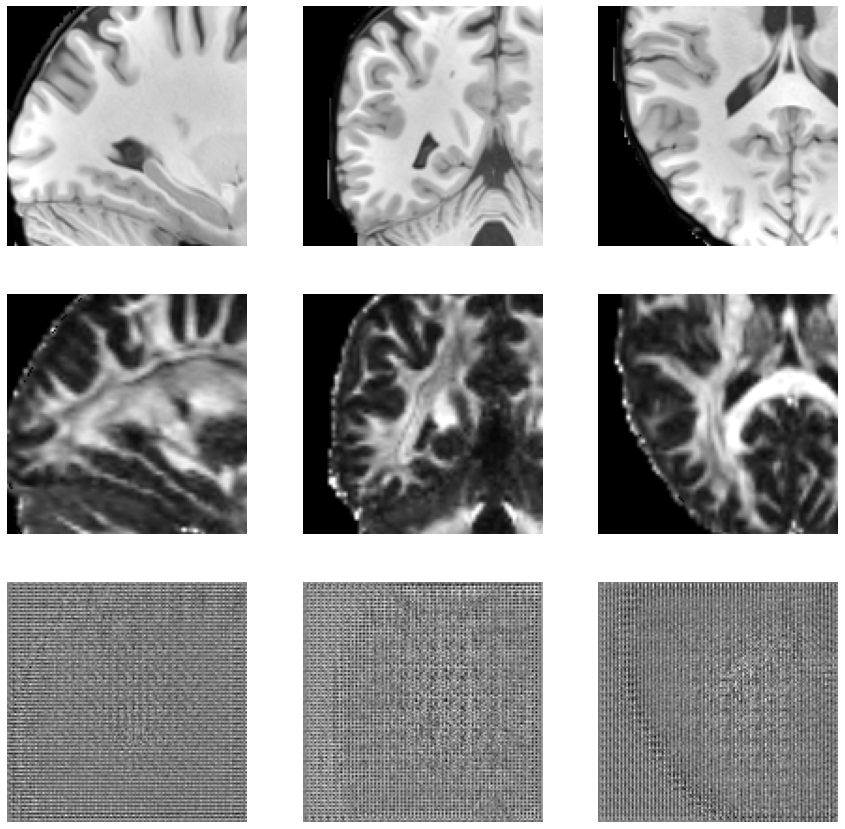

Validation loss decresaed from inf to 222.7358. Models' weights are now saved.
Epoch 6/800
Step: 6/800 - loss: 279.685181 - voxel_loss: 5.587158 - gan_disc_loss: 0.327264 - disc_loss: 0.360133
Time taken for 1 steps: 48.34 sec

Epoch 7/800


In [46]:
h=fit(train_ds,val_ds,steps=tot_step)
with open(f"{this_log_dir}/training_log.pic","wb") as f:
    pickle.dump(h,f)


In [ ]:
from units.base import show_process
show_process(h["train"],f"{this_log_dir}/train_process")
show_process(h["valid"],f"{this_log_dir}/valid_process")

### END

In [1]:
with open(f"{this_log_dir}/training_log.pic","rb") as f:
    t=pickle.load(f)

NameError: name 'this_log_dir' is not defined

In [12]:
import pickle
fin_log_dir="logs/GAN_fit/20220321-174833/"
with open(f"{fin_log_dir}training_log.pic","rb") as f:
    t=pickle.load(f)


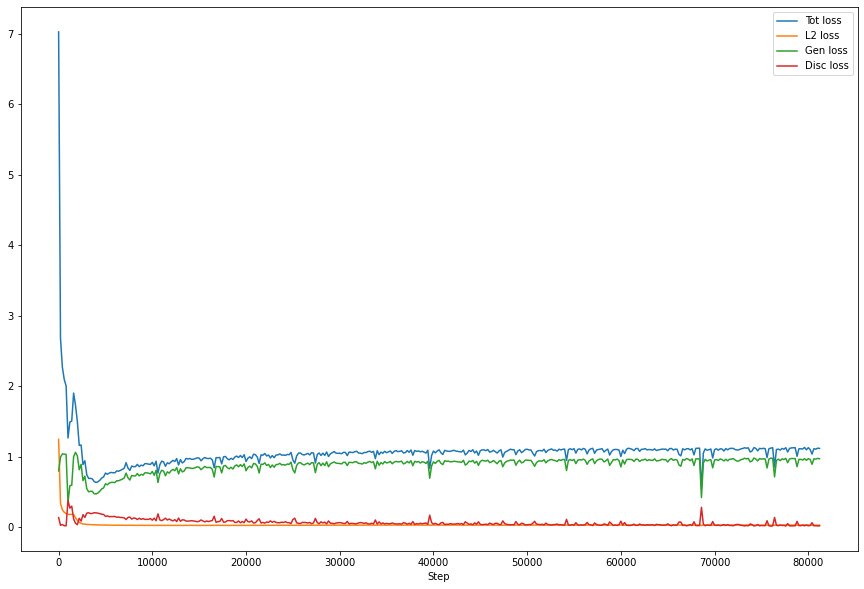

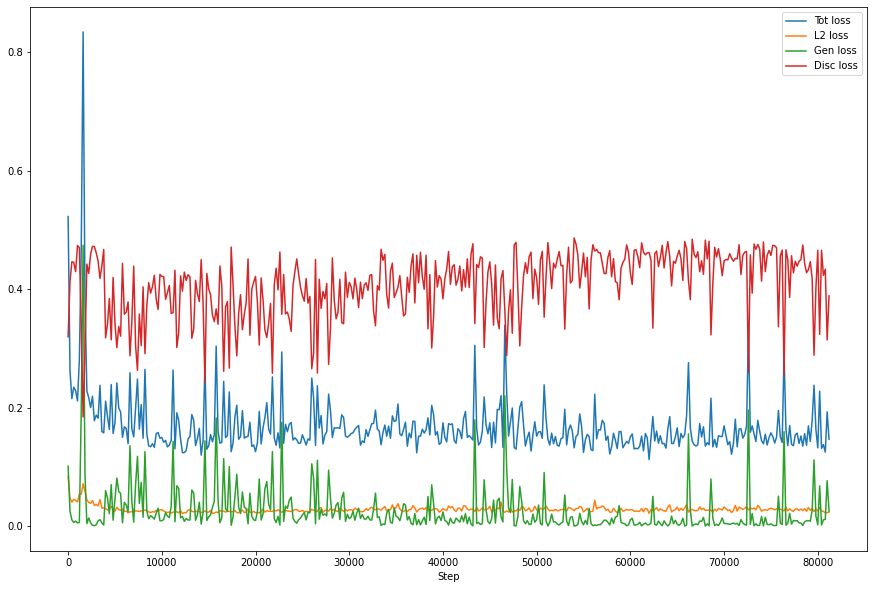

In [13]:
import matplotlib.pyplot as plt
def show_train_result(pic_data,save_path=None):
    plt.figure(figsize=(15,10))
    x=range(0,len(pic_data)*200,200)
    # plt.yscale('log')
    plt.xlabel("Step")
    plt.plot(x,pic_data,label=["Tot loss","L2 loss","Gen loss","Disc loss"])
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
# plt.plot(x,t["val"],label="GAN loss")
show_train_result(t["train"],fin_log_dir+"train_result")
show_train_result(t["valid"],fin_log_dir+"valid_result")

In [14]:
t["valid"]

[[0.52258694, 0.08419452, 0.10161432, 0.3196142],
 [0.26222363, 0.047355615, 0.025445554, 0.41322997],
 [0.2154403, 0.040860325, 0.011138673, 0.44611293],
 [0.23479886, 0.045636367, 0.00661703, 0.44535467],
 [0.22876568, 0.043955203, 0.008989634, 0.4295178],
 [0.2115236, 0.041147254, 0.005787342, 0.4737832],
 [0.28135133, 0.054898493, 0.0068588727, 0.46987432],
 [0.46648192, 0.054317225, 0.19489577, 0.3385318],
 [0.8338339, 0.07195315, 0.47406828, 0.1844671],
 [0.38355914, 0.059322804, 0.08694515, 0.2952498],
 [0.22836363, 0.04474494, 0.0046389443, 0.4423187],
 [0.21717101, 0.040599737, 0.0141723, 0.4266069],
 [0.20037931, 0.038856678, 0.0060959174, 0.4587651],
 [0.21951334, 0.043565728, 0.0016846869, 0.47236577],
 [0.17809898, 0.035337906, 0.0014094632, 0.47183475],
 [0.1876461, 0.03699836, 0.002654295, 0.46131265],
 [0.18232827, 0.034582008, 0.009418252, 0.44732937],
 [0.23783162, 0.045304313, 0.011310044, 0.41815343],
 [0.1599136, 0.030781774, 0.0060047447, 0.43900445],
 [0.15777409

In [ ]:
#try tensor.map
train_dataset = tf.data.Dataset.from_tensor_slices(train)
# d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
def upper_case_fn(t: np.ndarray):
    return t.decode('utf-8')+"1",t.decode('utf-8')+"2"
# d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
        #   inp=[x], Tout=tf.string))
# list(d.as_numpy_iterator())
train_dataset=train_dataset.map(lambda x:tf.numpy_function(func=upper_case_fn,inp=[x],Tout=(tf.float64,tf.float64)))
# train_dataset=train_dataset.map(lambda x:tf.strings.as_string(x)+"2")
list(train_dataset.as_numpy_iterator())
# len(train_dataset.map(np.array))
# for i in train_dataset:
    # print()#.numpy())


In [ ]:
from numpy.random import randint
d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
def upper_case_fn(t: np.ndarray):
  return (t.decode('utf-8')+str(randint(10))).upper()
d = d.map(lambda x: tf.numpy_function(func=upper_case_fn,
          inp=[x], Tout=tf.string),num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
list(d.repeat().take(10).as_numpy_iterator())
# list(d.as_numpy_iterator())

[b'HELLO3',
 b'WORLD3',
 b'HELLO9',
 b'WORLD2',
 b'HELLO9',
 b'WORLD5',
 b'HELLO4',
 b'WORLD2',
 b'HELLO8',
 b'WORLD2']

In [ ]:
class A:
    def __init__(self):
        self.t=10
    def exec(self,b):
        self.t+=b
a=[A()for i in range(4)]
b=[i for i in range(4)]
map(lambda x,y:x.exec(y),a,b)
a[2].t

12